# Calculating domain registration over time

Lipid-rafts are functional platforms in the plasma membrane that consist of $L_o$ lipids, and they act as sites for the aggregation of membrane-signalling proteins. Lipid-rafts are thought be very small, on the order of nanometers. Some pure lipid mixtures for so-called nanodomains - small regions of $L_o$ lipids in an otherwise $L_d$ bulk phase. These pure lipid mixtures are frequently used as approximations to lipid-rafts as they are much easier to study.

There is much interest in understanding under what conditions nanodomains in apposing leaflets are spatially aligned. Such alignment is known as interleaflet registration. The class `lipyphilic.lib.registration.Registration` can be used to quantify the degree of interleaflet registration in a planar bilayer.

`Registration` is an implementation of the registration analysis described by [Thallmair et al.](https://pubs.acs.org/doi/10.1021/acs.jpclett.8b01877) The degree of registration is calculated as the Pearson correlation coefficient of molecular densities in the upper and lower leaflets. First, the two-dimensional density of each leaflet is calculated:

$$
  \rho(x, y)_{L} = \displaystyle \int\limits_{-\infty}^{\infty} \frac{1}{2\pi\sigma^2} \exp \Bigg({-}\frac{1}{2} \bigg[ \bigg(\frac{x' - x}{\sigma} \bigg)^2 + \bigg(\frac{y' - y}{\sigma} \bigg)^2 \bigg] \Bigg) \,\text{d}x' \text{d}y'
$$

where the $(x, y)$ positions of lipid atoms in leaflet $L$ are binned into two-dimensional histograms with bin lengths of 1 Å. $L$ is either the upper ($u$) or lower ($l$) leaflet. The two-dimensional density is then convolved with a circular Gaussian density of standard deviation $\sigma$. 

The registration between the two leaflets, $r_{u/l}$, is then calculated as the Pearson correlation coefficient between $\rho(x, y)_{u}$ and $\rho(x, y)_{l}$. Values of $r_{u/l}=1$ correspond to perfectly registered domains and values of $r_{u/l}=-1$ correspond to perfectly anti-registered domains.

Below, we will look at the registration of $L_o$ lipids in a DPPC, DOPC, and cholesterol membrane simulated by [Smith et al.](https://www.biorxiv.org/content/10.1101/2021.05.24.445501v3).

In [4]:
import pathlib
import pickle

import numpy as np
import matplotlib.pyplot as plt

import MDAnalysis as mda
from lipyphilic.lib.registration import Registration


## Load the topology and trajectory using MDAnalysis

In [11]:
u = mda.Universe("../datafiles/dppc-dopc-chol.tpr", "../datafiles/dppc-dopc-chol.xtc")

## Load the leaflet information

To calculate interleaflet registration, we first need to know which leaflet each lipid is in at each frame. We will use the results from the notebook on [assigning lipids to leaflets](2-AssignLeaflets.ipynb).


In [5]:
with open("../results/leaflets/leaflets-dppc-dopc-chol.pkl", 'rb') as f:
    leaflets = pickle.load(f)
    

## Load data on lipid order information

To calculate interleaflet registration of $L_o$ lipids, we first need to know whether each lipid at each frame is $L_d$ or $L_o$.

[In another tutorial](HiddenMarkovModel.ipynb), we construct a hidden Markov model based on lipid thicknesses in order to determine whether each lipid in each frame is liquid-ordered ($L_o$) or liquid-disordered ($L_d$). We will use this information here in order to quantify to local lipid environments.


In [6]:
# Load the lipid order data
filename = "../results/HMM/lipid-order.npy"
lipid_order = np.load(filename)


`lipid_order` is a two-dimensional NumPy. Like many analyses in **lipyphilic**, the array is of shape ($N_{\rm lipids}$, $N_{\rm lipids}$) The:

- rows correspond to individual lipids
- columns correspond to individual frames.

In the array, the ordered state of each lipid is defined as follows:

- values of 1 indicate the lipid is in the $L_o$ state
- values of -1 indicate the lipid is in the $L_d$ state

Let's look at the array:


In [7]:
lipid_order

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ..., -1, -1, -1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       [ 1,  1,  1, ...,  1,  1,  1]], dtype=int8)

We see the first lipid (first row) is $L_o$ both at the beginning and end of the frames used in the analysis.

The second lipid (second row) is $L_o$ at the beginning of the analysis but $L_d$ at the end.



## Calculate interleaflet registration

To calculate the interleaflet registration, we will used the class `Registration`.

We need to pass a lipid selection for each leaflet (`upper_sel` and `lower_sel`), along with the leaflet membership (`leaflets`). As we wish to calculate the registration of $L_o$ lipids, we will pass a boolean mask to the `filter_by` keyword of `Registration`. A boolean mask is an array of `True` and `False` values, and in our case it will tell `Registration` whether or not to consider each lipid.


In [12]:
registration = Registration(
    universe=u,
    upper_sel="name GL1 GL2 ROH",    # select all lipids in the membrane
    lower_sel="name GL1 GL2 ROH",
    leaflets=leaflets.leaflets,      # pass the leaflet information
    filter_by=lipid_order == 1       # consider only L_o lipids
)


We then select which frames of the trajectory to analyse (`None` will use every frame) and choose to display a progress bar (`verbose=True`):
  

In [13]:
registration.run(
    start=None,
    stop=None,
    step=None,
    verbose=True
)


  0%|          | 0/51 [00:00<?, ?it/s]

## Accessing the results

The results are available in the `registration.registration` attribute as a NumPy array, in which:
- 1 corresponds to the leaflets being perfectly in register
- -1 corresponds to the leaflets being perfectly anti-registered


In [15]:
# There is one value for each frame
registration.registration.size

51

And we see the domains are highly registered

In [16]:
registration.registration

array([0.97084801, 0.96843655, 0.96961319, 0.96853573, 0.97056211,
       0.97047497, 0.96946172, 0.96612999, 0.96716027, 0.96948756,
       0.9703926 , 0.97050605, 0.97110132, 0.97084109, 0.97190522,
       0.97107553, 0.97268228, 0.97274188, 0.97161693, 0.96769835,
       0.9691056 , 0.97045798, 0.97245773, 0.97287451, 0.97232677,
       0.97060992, 0.96841088, 0.97083569, 0.97171274, 0.97303408,
       0.97402462, 0.9720658 , 0.97198342, 0.97217697, 0.97234439,
       0.971597  , 0.9738156 , 0.9710962 , 0.97297442, 0.97144168,
       0.97197271, 0.97214213, 0.97145197, 0.97317605, 0.97556718,
       0.97711723, 0.97403916, 0.97174973, 0.97285164, 0.97337764,
       0.97518734])

This is because the frame we are analysing are taken from the end of a simulation, after which phase-separation between $L_o$ and $L_d$ regions is complete.

## Plotting the results

We can plot the results to check whether the domains are becoming more registered over time:


Text(0.5, 0, 'Time ($\\rm \\mu s$)')

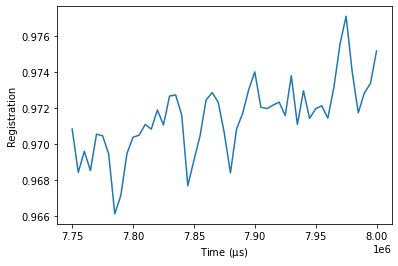

In [18]:
plt.plot(registration.times, registration.registration)

plt.ylabel("Registration")
plt.xlabel(r"Time ($\rm \mu s$)")
